# 扰动信号分类

## 构建一维CNN实现三类信号识别

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Activation, Conv1D, Add, Multiply, BatchNormalization, GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [6]:
# 加载数据集
X_train, X_val, X_test = [], [], []
Y_train, Y_val, Y_test = [], [], []
with open('train_data.txt','r') as f:
    for line in f:
        temp = line.strip().split(',')
        X_train.append([int(x) for x in temp])
with open('val_data.txt','r') as f:
    for line in f:
        temp = line.strip().split(',')
        X_val.append([int(x) for x in temp])
with open('test_data.txt','r') as f:
    for line in f:
        temp = line.strip().split(',')
        X_test.append([int(x) for x in temp])
with open('train_label.txt','r') as f:
    for line in f:
        Y_train.append(int(line.strip()))
with open('val_label.txt','r') as f:
    for line in f:
        Y_val.append(int(line.strip()))
with open('test_label.txt','r') as f:
    for line in f:
        Y_test.append(int(line.strip()))
X_train, X_val, X_test = np.array(X_train), np.array(X_val), np.array(X_test)
Y_train, Y_val, Y_test = np.array(Y_train), np.array(Y_val), np.array(Y_test)

In [7]:
# 升维
X_train, X_val, X_test = np.expand_dims(X_train,axis = 1),np.expand_dims(X_val,axis = 1),np.expand_dims(X_test,axis = 1)
Y_train, Y_val, Y_test = np.expand_dims(Y_train,axis = 1),np.expand_dims(Y_val,axis = 1),np.expand_dims(Y_test,axis = 1)

In [9]:
Y_train.shape

(4995, 1)

In [10]:
batch_size = 32

def batch_generator(x, y, batch_size=batch_size): 
    offset = 0
    while True:
        offset += batch_size
        
        if offset == batch_size or offset >= len(x):
            x, y = shuffle(x, y)
            offset = batch_size
            
        X_batch = x[offset - batch_size: offset]    
        Y_batch = y[offset - batch_size: offset]
        
        yield (X_batch, Y_batch)

In [23]:
epochs = 20
num_blocks = 3
filters = 64
drop_rate = 0.5
num_class = 3

X = Input(shape=(1,3750), dtype='float32')

def conv1d(inputs, filters, kernel_size, dilation_rate):
    return Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='causal', activation=None, dilation_rate=dilation_rate)(inputs)

def batchnorm(inputs):
    return BatchNormalization()(inputs)

def activation(inputs, activation):
    return Activation(activation)(inputs)

def res_block(inputs, filters, kernel_size, dilation_rate):
    hf = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'relu')
    hg = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'sigmoid')
    h0 = Multiply()([hf, hg])
    
    ha = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'relu')
    hs = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'relu')
    
    return Add()([ha, inputs]), hs

h0 = activation(batchnorm(conv1d(X, filters, 1, 1)), 'relu')
shortcut = []
for i in range(num_blocks):
    for r in [1, 2, 4, 8, 16]:
        h0, s = res_block(h0, filters, 7, r)
        shortcut.append(s)

h1 = activation(Add()(shortcut), 'relu')
h1 = activation(batchnorm(conv1d(h1, filters, 1, 1)), 'relu') # batch_size, seq_len, filters
h1 = batchnorm(conv1d(h1, num_class, 1, 1)) # batch_size, seq_len, num_class
h1 = GlobalMaxPooling1D()(h1) # batch_size, num_class
Y = activation(h1, 'softmax')

optimizer = Adam(lr=0.01, clipnorm=5)
model = Model(inputs=X, outputs=Y)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='zhuhai.h5', verbose=0)
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.000)

history = model.fit_generator(
    generator=batch_generator(X_train, Y_train), 
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs, 
    validation_data=batch_generator(X_val, Y_val), 
    validation_steps=len(X_val) // batch_size, 
    callbacks=[checkpointer, lr_decay])

Epoch 1/20
78/78 [==============================] - 290s 4s/step - loss: 0.4510 - accuracy: 0.8448 - val_loss: 0.8864 - val_accuracy: 0.5826
Epoch 2/20
78/78 [==============================] - 11s 146ms/step - loss: 0.1668 - accuracy: 0.9547 - val_loss: 0.4433 - val_accuracy: 0.8214
Epoch 3/20
78/78 [==============================] - 11s 140ms/step - loss: 0.0929 - accuracy: 0.9786 - val_loss: 0.1462 - val_accuracy: 0.9464
Epoch 4/20
78/78 [==============================] - 11s 140ms/step - loss: 0.0780 - accuracy: 0.9804 - val_loss: 0.3628 - val_accuracy: 0.8862
Epoch 5/20
78/78 [==============================] - 11s 141ms/step - loss: 0.0641 - accuracy: 0.9846 - val_loss: 0.2557 - val_accuracy: 0.9196
Epoch 6/20
78/78 [==============================] - 11s 138ms/step - loss: 0.0399 - accuracy: 0.9914 - val_loss: 0.1423 - val_accuracy: 0.9487
Epoch 7/20
78/78 [==============================] - 11s 147ms/step - loss: 0.0315 - accuracy: 0.9916 - val_loss: 0.1941 - val_accuracy: 0.9263
E

## 对比训练集与验证集的loss及准确率变化

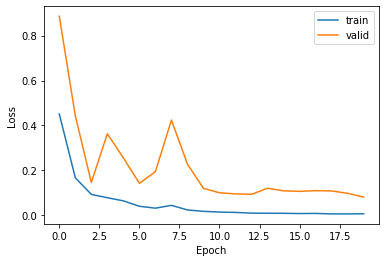

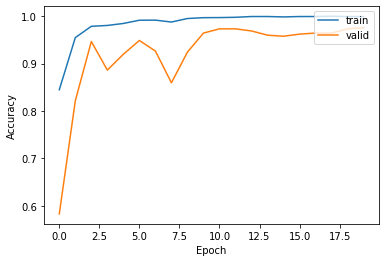

In [24]:
# 损失函数变化曲线
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## 在测试集上验证

In [25]:
# 准确率
print('训练集loss为{}，准确率为{}'.format(history.history['loss'][-1], history.history['accuracy'][-1]))
print('验证集loss为{}，准确率为{}'.format(history.history['val_loss'][-1], history.history['val_accuracy'][-1]))
score = model.evaluate(X_test, Y_test, verbose=0)
print('测试集loss为{}，准确率为{}'.format(score[0], score[1]))

训练集loss为0.006494189302126567，准确率为0.9989984035491943
验证集loss为0.08075833001307078，准确率为0.9754464030265808
测试集loss为0.08794098829259415，准确率为0.9640718698501587


In [26]:
# 对测试集任一信号进行分类
num = 1
prediction = model.predict(np.expand_dims(X_test[num],axis=0))
prediction = np.argmax(prediction, axis=1)[0]
label = ['foot','hand','stick']
print('预测结果是{}，其标签为{}'.format(label[prediction], label[int(Y_test[num][0])]))

预测结果是foot，其标签为foot


## 保存训练好的模型

In [27]:
# 保存模型
model.save('DVS2000.h5')
model.save_weights('DVS2000_weights.h5')

## 加载训练好的模型

In [6]:
from tensorflow.keras.models import load_model

In [7]:
model = load_model('DVS1210.h5')

W1210 08:20:22.705821 140666047768384 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1210 08:20:55.781458 140666047768384 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:460: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


In [8]:
num = 34
prediction = model.predict(np.expand_dims(X_test[num],axis=0))
prediction = np.argmax(prediction, axis=1)[0]
label = ['noraml','foot','hand','stick']
print('预测结果是{}，其标签为{}'.format(label[prediction], label[int(Y_test[num][0])]))

预测结果是stick，其标签为hand


In [10]:
score = model.evaluate(X_train, Y_train, verbose=0)
print('测试集loss为{}，准确率为{}'.format(score[0], score[1]))

测试集loss为2.307941883748716，准确率为0.2940940856933594
